# Predictor de Popularidade de Músicas

**Índice**<a id='toc0_'></a>    
1. [Introdução](#toc1_)    
2. [Preparação do notebook para R e Python em sumultâneo](#toc2_)    
3. [Importação dos módulos](#toc3_)    
4. [Exploração dos dados em bruto](#toc4_)    
4.1. [Upload dos dados](#toc4_1_)    
4.2. [Criação do dataframe](#toc4_2_)    
4.3. [Visualização do dataframe em bruto e de algumas métricas](#toc4_3_)    
5. [Análise Exploratória](#toc5_)    
5.1. [Distribuição dos valores em cada coluna](#toc5_1_)    
6. [Pré-processamento dos dados](#toc6_)    
6.1. [Identificação de Valores Ausentes](#toc6_1_)    
6.2. [Remoção de musicas com tempo 0](#toc6_2_)    
6.3. [Identificação e remoção de duplicados](#toc6_3_)    
6.4. [Definir o índice](#toc6_4_)    
6.5. [Remover coluna song_name](#toc6_5_)    
6.6. [Método do intervalo interquartil (IQR) para filtrar outliers](#toc6_6_)    
6.7. [Remoção de outliers com o z-score](#toc6_7_)    
6.8. [Remoção de outliers com Local Outlier Factor (LOF)](#toc6_8_)    
6.9. [Remoção de outliers variável a variável](#toc6_9_)    
6.10. [Gráficos comparativos da remoção dos outliers com os diferentes métodos](#toc6_10_)    
6.11. [Inferência](#toc6_11_)    
6.12. [Estatísticas do dataset](#toc6_12_)    
7. [Implementação de algoritmos de Aprendizagem Computacional](#toc7_)    
7.1. [Random Forest](#toc7_1_)    
7.1.1. [Matriz de confusão](#toc7_1_1_)    
7.1.2. [Divisão das variáveis dependentes e independentes](#toc7_1_2_)    
7.1.3. [Divisão em conjunto de treino e conjunto de teste](#toc7_1_3_)    
7.1.4. [Treino inicial do modelo](#toc7_1_4_)    
7.1.5. [RandomizedSearchCV](#toc7_1_5_)    
7.1.5.1. [Ver os melhores parâmetros do RandomizedSearchCV](#toc7_1_5_1_)    
7.1.6. [Função para avaliar o modelo](#toc7_1_6_)    
7.1.7. [Performance](#toc7_1_7_)    
7.1.8. [Afinação dos hiperparâmetros com o Grid Search Cross Validation](#toc7_1_8_)    
7.1.8.1. [Ver os melhores parâmetros do Grid Search Cross Validation](#toc7_1_8_1_)    
7.1.9. [Treino do modelo com os melhores hiperparâmetros](#toc7_1_9_)    
7.1.10. [Esquema árvore](#toc7_1_10_)    
7.2. [Árvore de Regressão](#toc7_2_)    
7.2.1. [Existem diferentes pacotes para modelar com árvores de decisão. Aqui usaremos o tree.](#toc7_2_1_)    
7.2.2. [Vamos dividir o conjunto de dados em dados de treio e de teste.](#toc7_2_2_)    
7.2.3. [Ajustamos uma árvore de regressão:](#toc7_2_3_)    
7.2.4. [O PROCESSO DE PODA](#toc7_2_4_)    
7.2.5. [A ÁRVIRE TMAX](#toc7_2_5_)    
7.2.6. [A PODA DA ÁRVIRE TMAX](#toc7_2_6_)    
7.3. [Bagging](#toc7_3_)    
8. [Resultados](#toc8_)    
9. [Considerações finais](#toc9_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Introdução](#toc0_)

## 2. <a id='toc2_'></a>[Preparação do notebook para R e Python em sumultâneo](#toc0_)

In [ ]:
! conda config --add channels r
! conda install --yes r-irkernel

In [4]:
# ! R -e "install.packages('IRkernel', repos = 'http://cran.us.r-project.org');IRkernel::installspec()"

In [18]:
! conda install rpy2

Retrieving notices: ...working... ^C
failed

CondaError: KeyboardInterrupt



In [19]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [7]:
#%%R -i df_no_outliers
#head(df_no_outliers) #Exemplo de utilização

## 3. <a id='toc3_'></a>[Importação dos módulos](#toc0_)

In [20]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt


## 4. <a id='toc4_'></a>[Exploração dos dados em bruto](#toc0_)

### 4.1. <a id='toc4_1_'></a>[Upload dos dados](#toc0_)

In [21]:
data = pd.read_csv('data/song_data.csv')

### 4.2. <a id='toc4_2_'></a>[Criação do dataframe](#toc0_)

In [22]:
df_raw = pd.DataFrame(data)

In [23]:
df_raw

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18830,Let It Breathe,60,159645,0.893000,0.500,0.151,0.000065,11,0.1110,-16.107,1,0.0348,113.969,4,0.300
18831,Answers,60,205666,0.765000,0.495,0.161,0.000001,11,0.1050,-14.078,0,0.0301,94.286,4,0.265
18832,Sudden Love (Acoustic),23,182211,0.847000,0.719,0.325,0.000000,0,0.1250,-12.222,1,0.0355,130.534,4,0.286
18833,Gentle on My Mind,55,352280,0.945000,0.488,0.326,0.015700,3,0.1190,-12.020,1,0.0328,106.063,4,0.323


### 4.3. <a id='toc4_3_'></a>[Visualização do dataframe em bruto e de algumas métricas](#toc0_)

In [24]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_name         18835 non-null  object 
 1   song_popularity   18835 non-null  int64  
 2   song_duration_ms  18835 non-null  int64  
 3   acousticness      18835 non-null  float64
 4   danceability      18835 non-null  float64
 5   energy            18835 non-null  float64
 6   instrumentalness  18835 non-null  float64
 7   key               18835 non-null  int64  
 8   liveness          18835 non-null  float64
 9   loudness          18835 non-null  float64
 10  audio_mode        18835 non-null  int64  
 11  speechiness       18835 non-null  float64
 12  tempo             18835 non-null  float64
 13  time_signature    18835 non-null  int64  
 14  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5), object(1)
memory usage: 2.2+ MB


In [25]:
df_raw.shape

(18835, 15)

1. **song_name** - Nome da música.
   - O título ou nome da música.

2. **song_popularity** - Popularidade da música de 0 a 100.
   - Um índice numérico que representa a popularidade da música, onde 0 indica nenhuma popularidade e 100 indica máxima popularidade.

3. **song_duration_ms** - Duração em ms.
   - A duração da música em milissegundos (ms).

4. **acousticness** - Acústica.
   - Uma medida de confiança de 0,0 a 1,0 de quão acústica a faixa é. Quanto mais próximo de 1,0, maior a probabilidade da faixa ser acústica.

5. **danceability** - Dançabilidade.
   - Descreve o quão adequada uma faixa é para dançar, baseada numa combinação de elementos musicais incluindo tempo, estabilidade do ritmo, força da batida e regularidade. O valor vai de 0,0 a 1,0, onde 1,0 é mais dançável.

6. **energy** - Energia.
   - Uma medida de 0,0 a 1,0 que representa a intensidade e atividade da faixa. Faixas energéticas tipicamente parecem rápidas, altas e ruidosas.

7. **instrumentalness** - Instrumentalidade.
   - Prediz a probabilidade de uma faixa não conter vocais. Sons "ooh" e "aah" são tratados como instrumentais nesta medida. Quanto mais próximo de 1,0, maior a probabilidade da faixa ser instrumental.

8. **key** - Tom.
   - A chave musical da faixa, onde cada inteiro mapeia para uma chave específica. Por exemplo, 0 = C, 1 = C♯/D♭, 2 = D, e assim por diante.

9. **liveness** - Vivacidade.
   - Detecta a presença de um público na gravação. Valores mais altos representam maior probabilidade da faixa ter sido gravada ao vivo. Um valor acima de 0,8 proporciona uma forte presença de público.

10. **loudness** - Volume.
    - O volume geral de uma faixa em decibéis (dB). Valores médios são normalmente entre -60 e 0 dB.

11. **audio_mode** - Modo Áudio.
    - Indica se a faixa está no modo maior (Major) ou menor (Minor), sendo 1 para maior e 0 para menor.

12. **speechiness** - Oralidade.
    - Detecta a presença de palavras faladas em uma faixa. Valores acima de 0,66 indicam faixas que provavelmente são inteiramente de palavras faladas.

13. **tempo** - Tempo.
    - O tempo estimado de uma faixa em batidas por minuto (BPM). Em geral, a faixa possui um tempo estável ao longo da música.

14. **time_signature** - Compasso.
    - Uma notação que indica o número de batidas em cada compasso ou medida. Valores comuns são 3, 4 e 5.

15. **audio_valence** - Valência Áudio.
    - Uma medida de positividade musical transmitida pela faixa, de 0,0 a 1,0. Faixas com valência alta soam mais positivas (por exemplo, felizes, alegres), enquanto faixas com valência baixa soam mais negativas (por exemplo, tristes, zangadas).

## 5. <a id='toc5_'></a>[Análise Exploratória](#toc0_)

### 5.1. <a id='toc5_1_'></a>[Distribuição dos valores em cada coluna](#toc0_)

In [26]:
col_names = df_raw.columns

col_names

Index(['song_name', 'song_popularity', 'song_duration_ms', 'acousticness',
       'danceability', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'audio_mode', 'speechiness', 'tempo', 'time_signature',
       'audio_valence'],
      dtype='object')

In [27]:
col_counts = {}

for col in col_names:
    col_counts[col] = df_raw[col].value_counts()

col_counts


{'song_name': song_name
 Better                                            21
 FEFE (feat. Nicki Minaj & Murda Beatz)            19
 MIA (feat. Drake)                                 18
 Taki Taki (with Selena Gomez, Ozuna & Cardi B)    18
 No Stylist                                        17
                                                   ..
 Bassride                                           1
 The Beat                                           1
 We Are the Brave - Fatum Remix                     1
 Long Live House Music                              1
 Up to Me                                           1
 Name: count, Length: 13070, dtype: int64,
 'song_popularity': song_popularity
 58     404
 52     389
 55     388
 60     383
 63     378
       ... 
 98      47
 97      36
 93      32
 99      16
 100     12
 Name: count, Length: 101, dtype: int64,
 'song_duration_ms': song_duration_ms
 165000    25
 180000    21
 212500    20
 189000    20
 179404    19
           ..
 219682 

In [28]:
df_raw.describe()

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
count,18835.000000,1.883500e+04,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000
mean,52.991877,2.182116e+05,0.258539,0.633348,0.644995,0.078008,5.289196,0.179650,-7.447435,0.628139,0.102099,121.073154,3.959119,0.527967
std,21.905654,5.988754e+04,0.288719,0.156723,0.214101,0.221591,3.614595,0.143984,3.827831,0.483314,0.104378,28.714456,0.298533,0.244632
min,0.000000,1.200000e+04,0.000001,0.000000,0.001070,0.000000,0.000000,0.010900,-38.768000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,1.843395e+05,0.024100,0.533000,0.510000,0.000000,2.000000,0.092900,-9.044000,0.000000,0.037800,98.368000,4.000000,0.335000
50%,56.000000,2.113060e+05,0.132000,0.645000,0.674000,0.000011,5.000000,0.122000,-6.555000,1.000000,0.055500,120.013000,4.000000,0.527000
75%,69.000000,2.428440e+05,0.424000,0.748000,0.815000,0.002570,8.000000,0.221000,-4.908000,1.000000,0.119000,139.931000,4.000000,0.725000
max,100.000000,1.799346e+06,0.996000,0.987000,0.999000,0.997000,11.000000,0.986000,1.585000,1.000000,0.941000,242.318000,5.000000,0.984000


## 6. <a id='toc6_'></a>[Pré-processamento dos dados](#toc0_)

### 6.1. <a id='toc6_1_'></a>[Identificação de Valores Ausentes](#toc0_)

In [29]:
df_raw.isnull().sum()

song_name           0
song_popularity     0
song_duration_ms    0
acousticness        0
danceability        0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
audio_mode          0
speechiness         0
tempo               0
time_signature      0
audio_valence       0
dtype: int64

### 6.2. <a id='toc6_2_'></a>[Remoção de musicas com tempo 0](#toc0_)

In [30]:
df_raw.drop(df_raw[(df_raw['tempo']==0)].index, inplace=True)

### 6.3. <a id='toc6_3_'></a>[Identificação e remoção de duplicados](#toc0_)

In [31]:
# Remover duplicatas considerando todas as colunas
df_raw.drop_duplicates(inplace=True)


In [32]:
df_raw.shape

(14924, 15)

### 6.4. <a id='toc6_4_'></a>[Definir o índice](#toc0_)

In [33]:
df_raw.set_index(pd.RangeIndex(start=0, stop=len(df_raw), step=1), inplace=True)

### 6.5. <a id='toc6_5_'></a>[Remoção da coluna song_name](#toc0_)

In [34]:
df_raw.drop(columns='song_name', inplace=True)


### 6.6. <a id='toc6_6_'></a>[Remoção de outliers com o método do intervalo interquartil (IQR)](#toc0_)

In [35]:
numeric_columns = df_raw.select_dtypes(include='number')

# Calcula Q1, Q3 e IQR para cada coluna numérica
Q1 = numeric_columns.quantile(0.25)
Q3 = numeric_columns.quantile(0.75)
IQR = Q3 - Q1

# Define os limites para identificar outliers
lower_bound = Q1 - 1.5 * IQR 
upper_bound = Q3 + 1.5 * IQR

# Identifica e remove outliers
outliers = ((numeric_columns < lower_bound) | (numeric_columns > upper_bound)).any(axis=1)
df_IQR = df_raw[~outliers]
df_IQR.shape

(8609, 14)

### 6.7. <a id='toc6_7_'></a>[Remoção de outliers com o método do Z-Score](#toc0_)

In [36]:
# Calcular os z-scores para todas as colunas
z_scores = np.abs(stats.zscore(df_raw))

# Definir um threshold para outliers (por exemplo, Z-score < 3)
threshold = 3

# Manter as linhas onde os z-scores são menores que o threshold para todas as colunas
df_Z = df_raw[(z_scores < threshold).all(axis=1)]
df_Z.shape

(12489, 14)

In [37]:
df_Z

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14919,60,159645,0.893000,0.500,0.151,0.000065,11,0.1110,-16.107,1,0.0348,113.969,4,0.300
14920,60,205666,0.765000,0.495,0.161,0.000001,11,0.1050,-14.078,0,0.0301,94.286,4,0.265
14921,23,182211,0.847000,0.719,0.325,0.000000,0,0.1250,-12.222,1,0.0355,130.534,4,0.286
14922,55,352280,0.945000,0.488,0.326,0.015700,3,0.1190,-12.020,1,0.0328,106.063,4,0.323


### 6.8. <a id='toc6_8_'></a>[Remoção de outliers com o método do Local Outlier Factor (LOF)](#toc0_)

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor

# Supondo que df_raw é o seu DataFrame carregado com várias colunas
# Se df_raw não estiver definido, você pode carregá-lo assim:
# df_raw = pd.read_csv('caminho/para/seu/arquivo.csv')

# Load the dataset
X = df_raw

# Create the LocalOutlierFactor model for outlier detection
lof_outlier = LocalOutlierFactor(n_neighbors=20)

# Fit the model to the data and predict the outlier scores for each data point
outlier_scores = lof_outlier.fit_predict(X)

# Identify the outlier data points
outlier_indices = outlier_scores == -1
print("Outlier indices:", outlier_indices)

# Remover os outliers do DataFrame
df_LOF = X[~outlier_indices]
df_LOF.shape

Outlier indices: [False False False ... False False False]


(14885, 14)

In [39]:
df_IQR

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.4740
1,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.3700
3,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.1980
4,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.5740
5,80,235893,0.008950,0.316,0.945,0.000002,4,0.3960,-3.169,0,0.1240,189.931,4,0.3200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14917,55,114582,0.898000,0.370,0.136,0.000263,7,0.0999,-13.528,1,0.0433,146.081,4,0.0592
14918,62,195106,0.395000,0.644,0.523,0.000000,4,0.0930,-7.660,1,0.0378,95.966,4,0.4450
14920,60,205666,0.765000,0.495,0.161,0.000001,11,0.1050,-14.078,0,0.0301,94.286,4,0.2650
14921,23,182211,0.847000,0.719,0.325,0.000000,0,0.1250,-12.222,1,0.0355,130.534,4,0.2860


### 6.9. <a id='toc6_9_'></a>[Remoção de outliers com o método Variável a Variável](#toc0_)

In [40]:
%%R

install.packages("pls")
library(pls)
library(psych) 
library(readr)
library(tree)
library(caret)
library(gbm)
library(rpart)
library(rpart.plot)
library(randomForest)
library(caret)
library(pROC)
library(ggplot2)
library(reshape2)




The downloaded binary packages are in
	/var/folders/km/dt_l1qsx1kvdth2cmx91yspm0000gn/T//RtmpQs4QHw/downloaded_packages


trying URL 'https://mirrors.cicku.me/cran/bin/macosx/big-sur-x86_64/contrib/4.3/pls_2.8-3.tgz'
Content type 'application/gzip' length 1183010 bytes (1.1 MB)
downloaded 1.1 MB



In [29]:
%%R -i df_raw

data = df_raw

data.numeric <- data[,sapply(data, is.numeric)]
head(data.numeric)


  song_popularity song_duration_ms acousticness danceability energy
0              73           262333     0.005520        0.496  0.682
1              66           216933     0.010300        0.542  0.853
2              76           231733     0.008170        0.737  0.463
3              74           216933     0.026400        0.451  0.970
4              56           223826     0.000954        0.447  0.766
5              80           235893     0.008950        0.316  0.945
  instrumentalness key liveness loudness audio_mode speechiness   tempo
0         2.94e-05   8   0.0589   -4.095          1      0.0294 167.060
1         0.00e+00   3   0.1080   -6.407          0      0.0498 105.256
2         4.47e-01   0   0.2550   -7.828          1      0.0792 123.881
3         3.55e-03   0   0.1020   -4.938          1      0.1070 122.444
4         0.00e+00  10   0.1130   -5.065          1      0.0313 172.011
5         1.85e-06   4   0.3960   -3.169          0      0.1240 189.931
  time_signature aud

In [30]:
%%R
#################CATEGORIZAÇÃO DOS DADOS##################

quartiles <- quantile(data$song_popularity, probs = c(0, 0.25, 0.5, 0.75, 0.95), na.rm = TRUE)
breaks <- c(quartiles[1:5], Inf)
labels <- c(1,2,3,4,5)
data$song_category <- cut(data$song_popularity, breaks = breaks, labels = labels, include.lowest = TRUE)
summary(data$song_category)
data$song_name<-NULL
head(data)

  song_popularity song_duration_ms acousticness danceability energy
0              73           262333     0.005520        0.496  0.682
1              66           216933     0.010300        0.542  0.853
2              76           231733     0.008170        0.737  0.463
3              74           216933     0.026400        0.451  0.970
4              56           223826     0.000954        0.447  0.766
5              80           235893     0.008950        0.316  0.945
  instrumentalness key liveness loudness audio_mode speechiness   tempo
0         2.94e-05   8   0.0589   -4.095          1      0.0294 167.060
1         0.00e+00   3   0.1080   -6.407          0      0.0498 105.256
2         4.47e-01   0   0.2550   -7.828          1      0.0792 123.881
3         3.55e-03   0   0.1020   -4.938          1      0.1070 122.444
4         0.00e+00  10   0.1130   -5.065          1      0.0313 172.011
5         1.85e-06   4   0.3960   -3.169          0      0.1240 189.931
  time_signature aud

[1] 4


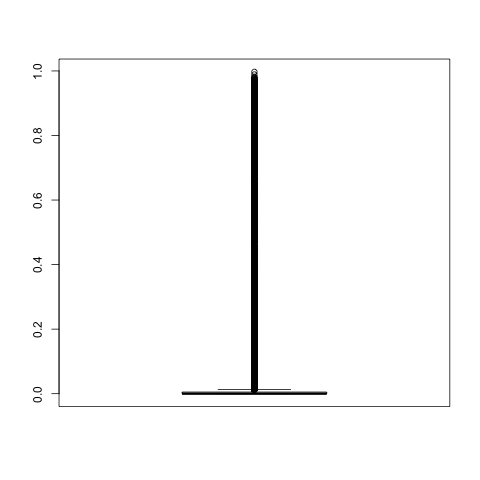

In [31]:
%%R
#################LIMPEZA DE OUTLIERS#################

boxplot(data$song_duration_ms)

boxplot(data$instrumentalness)
ggplot(data, aes(x = song_category, y = song_duration_ms)) +
  geom_boxplot() +
  labs(title = "Box plot of Your Variable by Song Category",
       x = "Song Category",
       y = "song_duration_ms")


threshold <- 1000000  # limite dos outliers (limite)
data <- data[data$song_duration_ms <= threshold, ]
dim(data)
18835-18831 ##4 outliers eliminados

In [32]:
%%R
#####Variavel acousticness

ggplot(data, aes(x = song_category, y = acousticness)) +
  geom_boxplot() +
  labs(title = "Box plot of Your Variable by Song Category",
       x = "Song Category",
       y = "Acousticness")

# Definir o limite (threshold)
threshold1 <- 0.98
data <- data[!(data$song_category == "Popular" & data$acousticness > threshold1), ]
head(data)
18835-18814 ##21 outliers eliminados

[1] 21


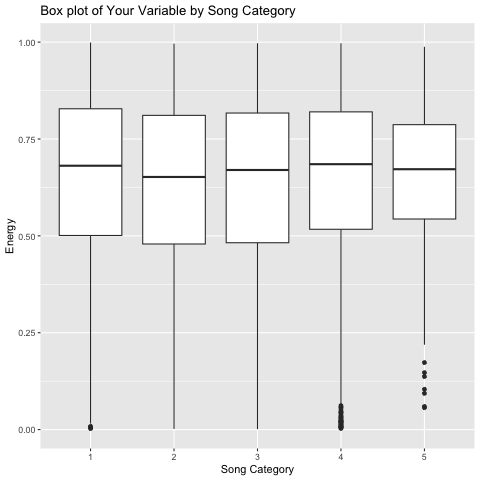

In [33]:
%%R
#####Variavel Energy
##Não é preciso eliminar outliers

ggplot(data, aes(x = song_category, y = energy
)) +
  geom_boxplot() +
  labs(title = "Box plot of Your Variable by Song Category",
       x = "Song Category",
       y = "Energy")


In [34]:
%%R
#####Variavel Speechiness

ggplot(data, aes(x = song_category, y = speechiness
)) +
  geom_boxplot() +
  labs(title = "Box plot of Your Variable by Song Category",
       x = "Song Category",
       y = "Speechiness")

threshold1 <- 0.9  
threshold2 <- 0.9 
threshold3 <- 0.75
threshold4 <- 0.5
data <- data[!(data$song_category == "Not_popular" & data$speechiness > threshold1), ]
data <- data[!(data$song_category == "Low_popularity" & data$speechiness > threshold2), ]
data <- data[!(data$song_category == "Radio_friendly" & data$speechiness > threshold3), ]
data <- data[!(data$song_category == "Popular" & data$speechiness > threshold4), ]

dim(data)
18831-18794 ##37 outliers eliminados

[1] 37


In [35]:
%%R
####Variavel Loudness

ggplot(data, aes(x = song_category, y = loudness
)) +
  geom_boxplot() +
  labs(title = "Box plot of Your Variable by Song Category",
       x = "Song Category",
       y = "Loudness")
threshold1=-35
data <- data[!(data$loudness < threshold1), ]
dim(data)
18831-18788 ##43 outliers eliminados

[1] 43


In [36]:
%%R
###Variavel Speechiness

ggplot(data, aes(x = song_category, y = speechiness
)) +
  geom_boxplot() +
  labs(title = "Box plot of Your Variable by Song Category",
       x = "Song Category",
       y = "Speechiness")

threshold1=0.85
data <- data[!(data$speechiness > threshold1), ]
dim(data)
18831-18783 ##48 outliers eliminados

[1] 48


In [37]:
%%R
##Variavel Tempo
ggplot(data, aes(x = song_category, y = tempo
)) +
  geom_boxplot() +
  labs(title = "Box plot of Your Variable by Song Category",
       x = "Song Category",
       y = "Tempo")
threshold1=230
threshold2=0
data <- data[!(data$tempo > threshold1), ]
data <- data[!(data$tempo <= threshold2), ]
dim(data)
18831-18780 ##51 outliers eliminados

[1] 51


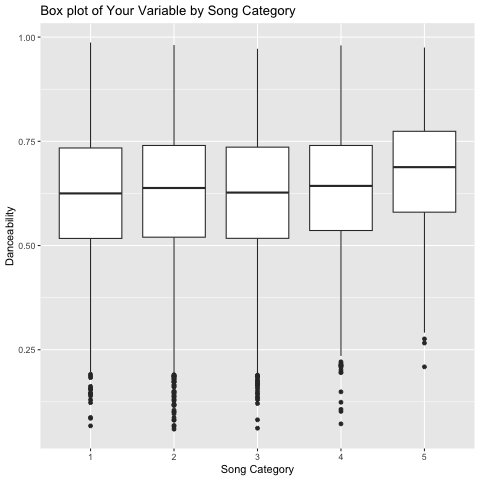

In [38]:
%%R
##Variavel Danceability
ggplot(data, aes(x = song_category, y = danceability
)) +
  geom_boxplot() +
  labs(title = "Box plot of Your Variable by Song Category",
       x = "Song Category",
       y = "Danceability")

##Não são eliminados outliers nesta variavel

In [39]:

%%R
## 51/18831 = 0.003 percentagem de elementos removidos do dataset. 
## Limpeza muito minuciosa e pormenorizada.

#### Estamos em condições de aplicar as metodologias. 

df_VAR <- data.frame(data)

In [40]:
# Importar o DataFrame de R para Python
df_VAR = %R df_VAR



In [41]:
df_VAR.set_index(pd.RangeIndex(start=1, stop=len(df_VAR)+1, step=1), inplace=True)

In [42]:
df_VAR.shape

(14903, 15)

### 6.10. <a id='toc6_10_'></a>[Gráficos comparativos da remoção dos outliers com os diferentes métodos](#toc0_)

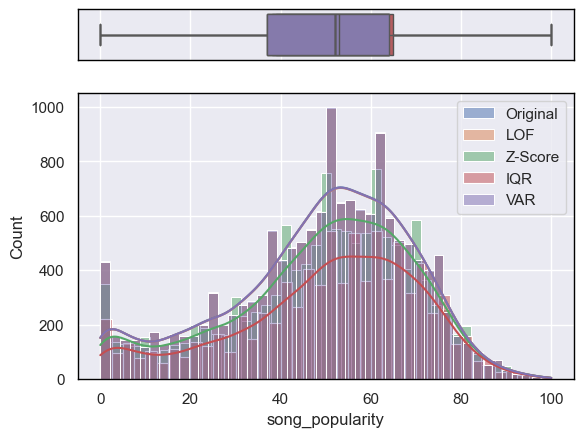

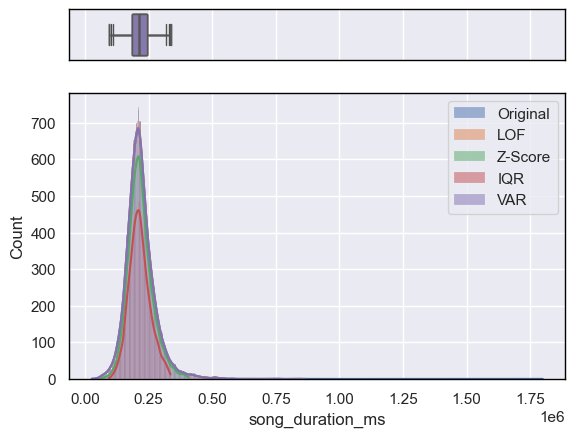

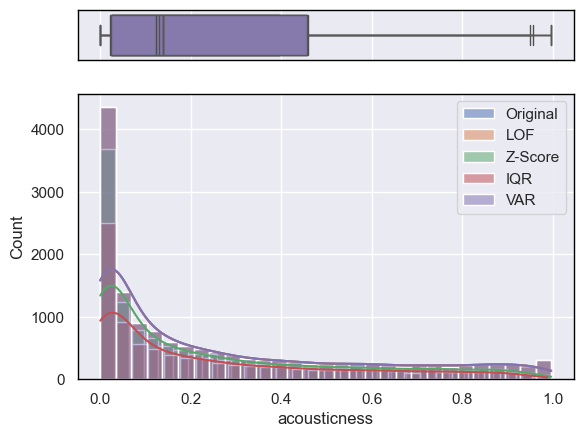

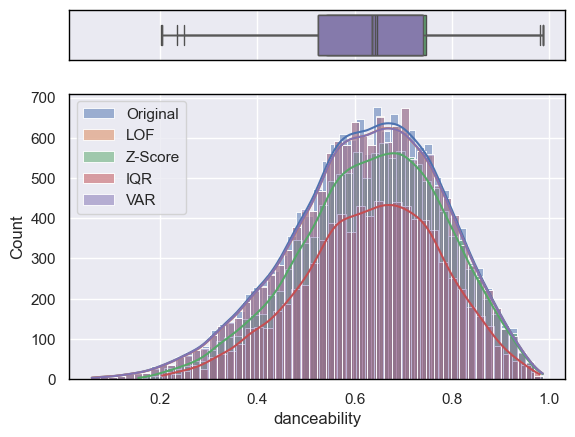

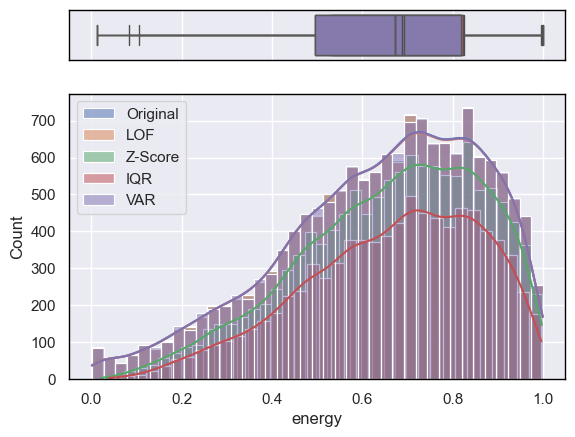

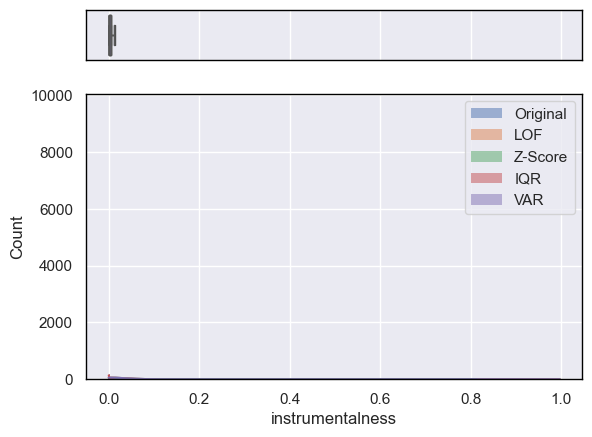

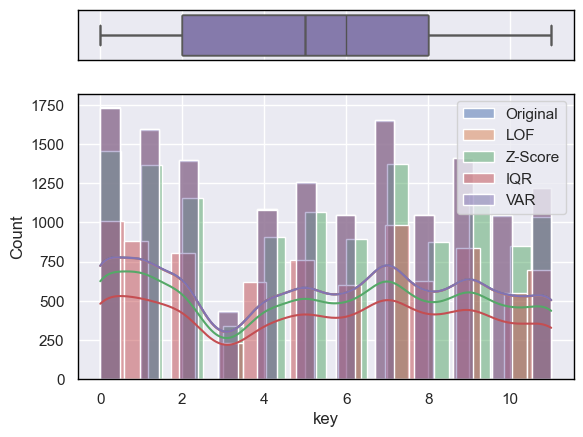

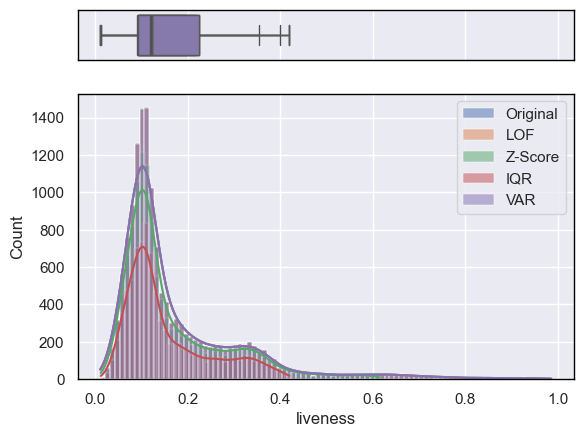

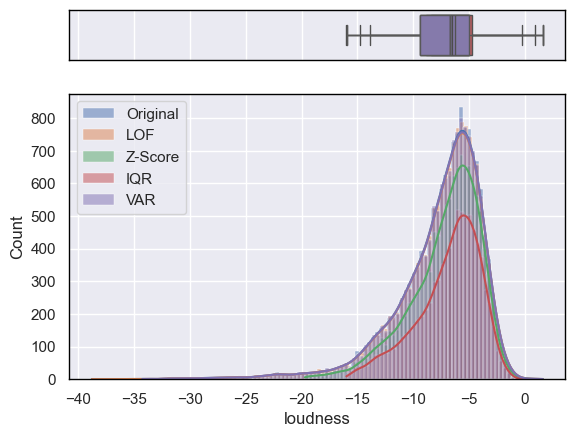

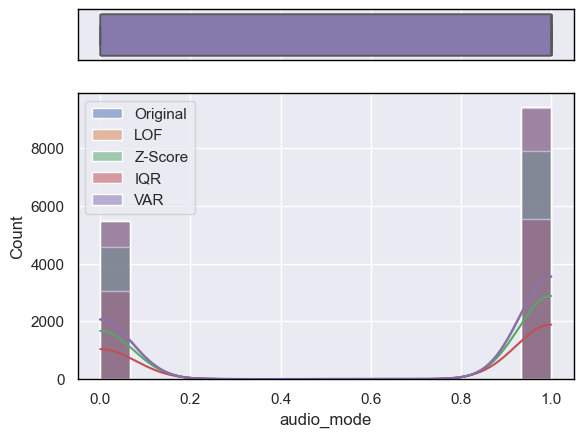

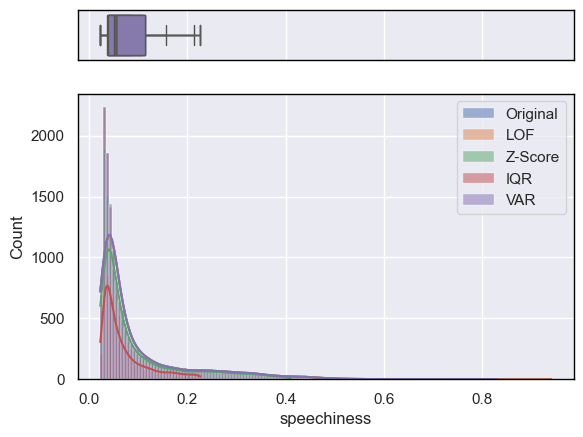

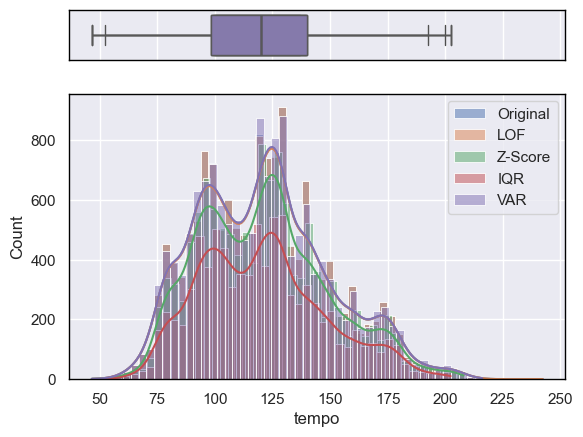

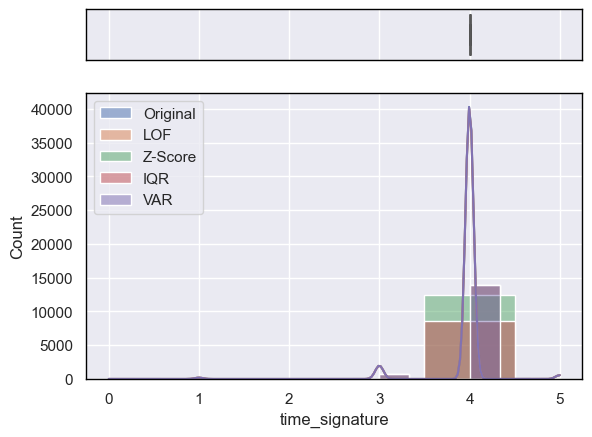

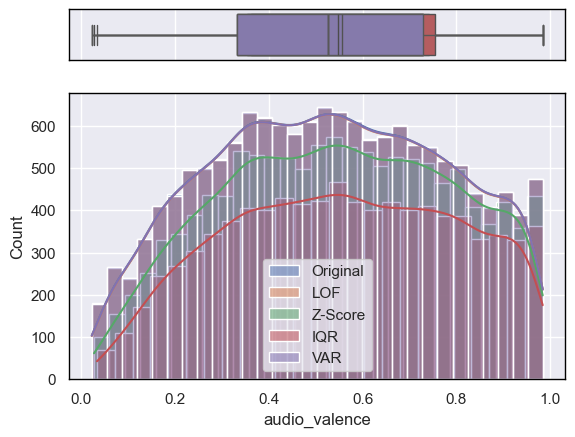

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

variables = X.columns
data_frames = [('Original', X), ('LOF', df_LOF), ('Z-Score', df_Z), ('IQR', df_IQR), ('VAR', df_VAR)]

for variable in variables:
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    
    for label, df in data_frames:
        sns.boxplot(x=df[variable], orient="h", ax=ax_box, whis=1.5, showfliers=False)
        sns.histplot(data=df, x=variable, ax=ax_hist, kde=True, label=label)
    
    ax_box.set(xlabel='')
    ax_hist.legend()
    
    # Adicionando borda preta em torno de cada imagem
    for ax in [ax_box, ax_hist]:
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)

    plt.show()


### 6.11. <a id='toc6_11_'></a>[Inferência](#toc0_)

Conjunto de dados original: 18835 amostras.

Após remoção de NA: 18835 amostras.

Após remoção de duplicados: 14924 amostras.

Após Intervalo Interquartil: 8609 amostras

Após Z-score: 12489 amostras

Após Local Outlier Factor: 14885 amostras

Após Variável a Variável: 14903 amostras


### 6.12. <a id='toc6_12_'></a>[Estatísticas do dataset](#toc0_)

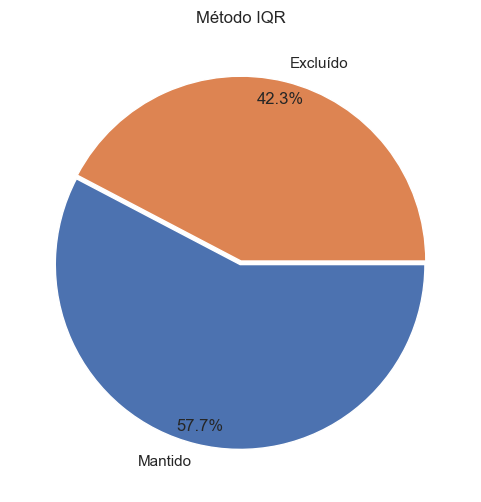

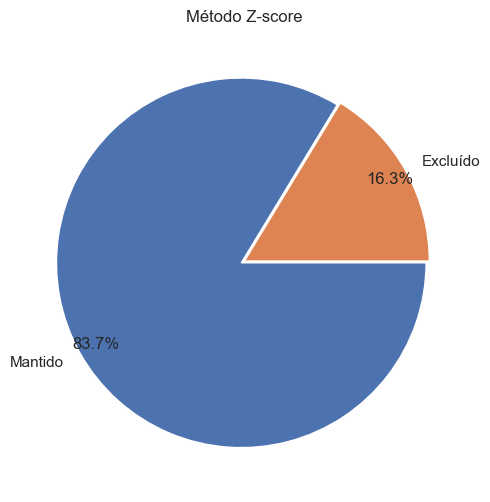

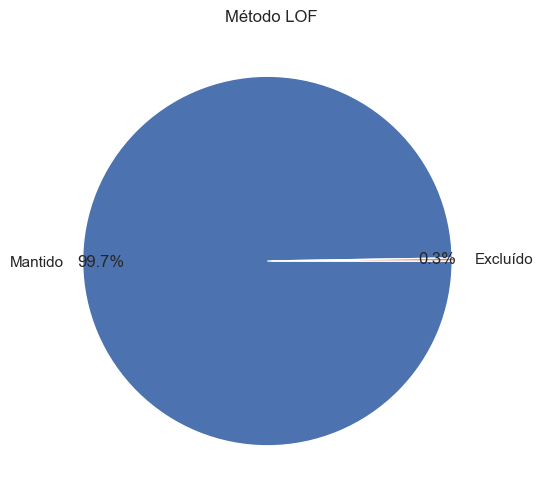

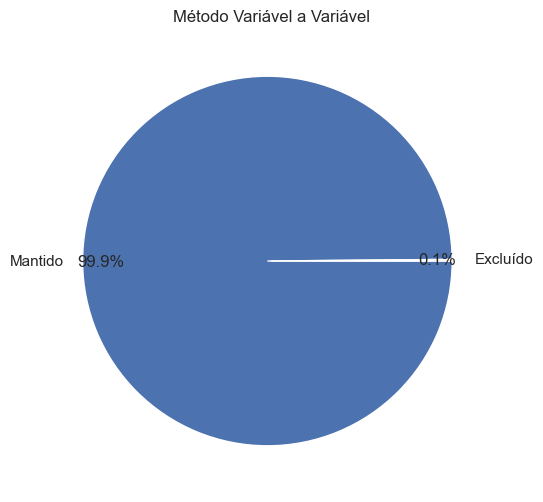

In [44]:
import matplotlib.pyplot as plt

# Definindo as cores
sns.set_theme(style="darkgrid")

methods = [('Método IQR', df_IQR), ('Método Z-score', df_Z), ('Método LOF', df_LOF), ('Método Variável a Variável', df_VAR)]

for title, df in methods:
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(title)
    ax.pie([df.shape[0], df_raw.shape[0] - df.shape[0]],
           radius=1,
           labels=['Mantido', 'Excluído'],
           counterclock=False,
           autopct='%1.1f%%',
           pctdistance=0.9,
           explode=[0.02, 0],
           shadow=False)
    plt.show()


## 7. <a id='toc7_'></a>[Implementação de algoritmos de Aprendizagem Computacional](#toc0_)

### 7.1. <a id='toc7_1_'></a>[Random Forest](#toc0_)

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/

#### 7.1.2. <a id='toc7_1_2_'></a>[Divisão das variáveis dependentes e independentes](#toc0_)

In [45]:
from sklearn.model_selection import train_test_split

def preprocess_data(df):
    m = [i.replace(' ','_') for i in df.columns.values]
    df.columns = m
    X = df[['song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'audio_mode', 'speechiness', 'tempo', 'time_signature', 'audio_valence']]
    X.loc[:, ['key', 'audio_mode', 'time_signature']] = X.loc[:, ['key', 'audio_mode', 'time_signature']].astype('category')
    Y = df["song_popularity"]
    return X, Y

#### 7.1.3. <a id='toc7_1_3_'></a>[Divisão em conjunto de treino e conjunto de teste](#toc0_)

In [46]:
# Lista de dados e etiquetas
conjuntos_dados = [(df_IQR, "IQR"), (df_Z, "Z"), (df_LOF, "LOF"), (df_VAR, "VAR")]

# Escolha o conjunto de dados que deseja processar (por exemplo, o 3º conjunto de dados)
indice_selecionado = 2
df_selecionado, nome_selecionado = conjuntos_dados[indice_selecionado]

X, Y = preprocess_data(df_selecionado)

# Divisão dos dados em conjuntos de treinamento e teste
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=42)
Train_X.reset_index(drop=True, inplace=True)

print('Conjunto original (100%) para', nome_selecionado, ': ', X.shape, Y.shape)
print('Conjunto de treino (80%) para', nome_selecionado, ': ', Train_X.shape, Train_Y.shape)
print('Conjunto de teste (20%) para', nome_selecionado, ': ', Test_X.shape, Test_Y.shape)

Conjunto original (100%) para LOF :  (14885, 13) (14885,)
Conjunto de treino (80%) para LOF :  (11908, 13) (11908,)
Conjunto de teste (20%) para LOF :  (2977, 13) (2977,)


#### 7.1.4. <a id='toc7_1_4_'></a>[Treino inicial do modelo](#toc0_)

In [47]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn import set_config

# Escolha RandomForestClassifier para problemas de classificação e RandomForestRegressor para regressão
model = RandomForestRegressor(random_state=42)  # ou RandomForestRegressor

# Treinar o modelo
model.fit(Train_X, Train_Y)

RandomForestRegressor(random_state=42)

#### 7.1.5. <a id='toc7_1_5_'></a>[RandomizedSearchCV](#toc0_)

In [51]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 800, stop = 2000, num = 5)],      # Número de árvores in the forest
    'max_features': ['sqrt'],     # Número de features a serem consideradas para divisão
    'max_depth': [int(x) for x in np.linspace(10, 50, num = 5)],      # Profundidade máxima da árvore
    'min_samples_split': [2, 5, 10],      # Número mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 4],        # Número mínimo de amostras num nó folha
    'bootstrap': [True, False]
    
}


model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Treinar o modelo
model_random.fit(Train_X, Train_Y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time= 2.3min
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time= 2.4min
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time= 2.4min
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time= 2.4min
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time= 1.1min
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time= 1.1min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimato

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [800, 1100, 1400, 1700,
                                                         2000]},
                   random_state=42, verbose=2)

##### 7.1.5.1. <a id='toc7_1_5_1_'></a>[Ver os melhores parâmetros do RandomizedSearchCV](#toc0_)

In [52]:
model_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

#### 7.1.6. <a id='toc7_1_6_'></a>[Função para avaliar o modelo](#toc0_)

In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
import math

def print_errors(model, Test_X, Test_Y):
    predictions = model.predict(Test_X)
    mae = mean_absolute_error(Test_Y, predictions)
    mse = mean_squared_error(Test_Y, predictions)
    rmse = math.sqrt(mse)
    r2 = r2_score(Test_Y, predictions)
    
    print('Erro absoluto médio do modelo: {:.4f}'.format(mae))
    print('Mean squared error do modelo: {:.4f}'.format(mse))
    print('Root mean squared error do modelo: {:.4f}'.format(rmse))
    print('O valor de r2 do modelo: {:.4f}'.format(r2))
    print('')
    
    return rmse

#### 7.1.7. <a id='toc7_1_7_'></a>[Performance](#toc0_)

In [54]:
# BASE
print("________________MODELO BASE________________")
base_rmse = print_errors(model, Test_X, Test_Y)
# RANDOM SEARCH
print("________________MODELO COM RANDOM SEARCH________________")
random_rmse = print_errors(model_random, Test_X, Test_Y)
print("_________________________________________________________")
print('MELHORIA DE {:0.2f}%.'.format( 100 * (base_rmse-random_rmse) / base_rmse))

________________MODELO BASE________________
Erro absoluto médio do modelo: 16.1216
Mean squared error do modelo: 414.2759
Root mean squared error do modelo: 20.3538
O valor de r2 do modelo: 0.0054

________________MODELO COM RANDOM SEARCH________________


Erro absoluto médio do modelo: 15.8462
Mean squared error do modelo: 398.1731
Root mean squared error do modelo: 19.9543
O valor de r2 do modelo: 0.0440

_________________________________________________________
MELHORIA DE 1.96%.


#### 7.1.8. <a id='toc7_1_8_'></a>[Afinação dos hiperparâmetros com o Grid Search Cross Validation](#toc0_)

In [56]:
param_grid = {
    'n_estimators': [1200, 1400, 1600],
    'min_samples_split': [8, 10, 12],
    'min_samples_leaf': [3, 4, 5],
    'max_features': ['sqrt'],
    'max_depth': [40, 50, 60],
    'bootstrap': [True]
    }

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Executar o GridSearchCV
grid_search.fit(Train_X, Train_Y)


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=1200; total time=  42.4s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=1200; total time=  42.6s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=1200; total time=  42.8s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=1400; total time=  50.0s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=1400; total time=  53.9s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=1400; total time=  54.0s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=1600; total time= 1.0min
[CV] END bootstrap=True, max_depth=40, ma

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [40, 50, 60],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [1200, 1400, 1600]},
             verbose=2)

##### 7.1.8.1. <a id='toc7_1_8_1_'></a>[Ver os melhores parâmetros do Grid Search Cross Validation](#toc0_)

In [57]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 12,
 'n_estimators': 1200}

In [58]:
# BASE
print("________________MODELO BASE________________")
base_rmse = print_errors(model, Test_X, Test_Y)
# RANDOM SEARCH
print("_______MODELO COM GRID SEARCH CROSS VALIDATION_______")
grid_search_rmse = print_errors(grid_search, Test_X, Test_Y)
print("_________________________________________________________")
print('MELHORIA DE {:0.2f}%.'.format( 100 * (base_rmse-grid_search_rmse) / base_rmse))

________________MODELO BASE________________
Erro absoluto médio do modelo: 16.1216
Mean squared error do modelo: 414.2759
Root mean squared error do modelo: 20.3538
O valor de r2 do modelo: 0.0054

_______MODELO COM GRID SEARCH CROSS VALIDATION_______
Erro absoluto médio do modelo: 15.8387
Mean squared error do modelo: 397.9086
Root mean squared error do modelo: 19.9476
O valor de r2 do modelo: 0.0447

_________________________________________________________
MELHORIA DE 2.00%.


#### 7.1.9. <a id='toc7_1_9_'></a>[Treino do modelo com os melhores hiperparâmetros](#toc0_)

In [59]:
# Criar um novo modelo com os melhores hiperparâmetros
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

best_model = RandomForestRegressor(**best_params, random_state=42)

# Treinar o modelo
best_model.fit(Train_X, Train_Y)



RandomForestRegressor(max_depth=50, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=12, n_estimators=1200, random_state=42)

#### 7.1.10. <a id='toc7_1_10_'></a>[Esquema árvore](#toc0_)

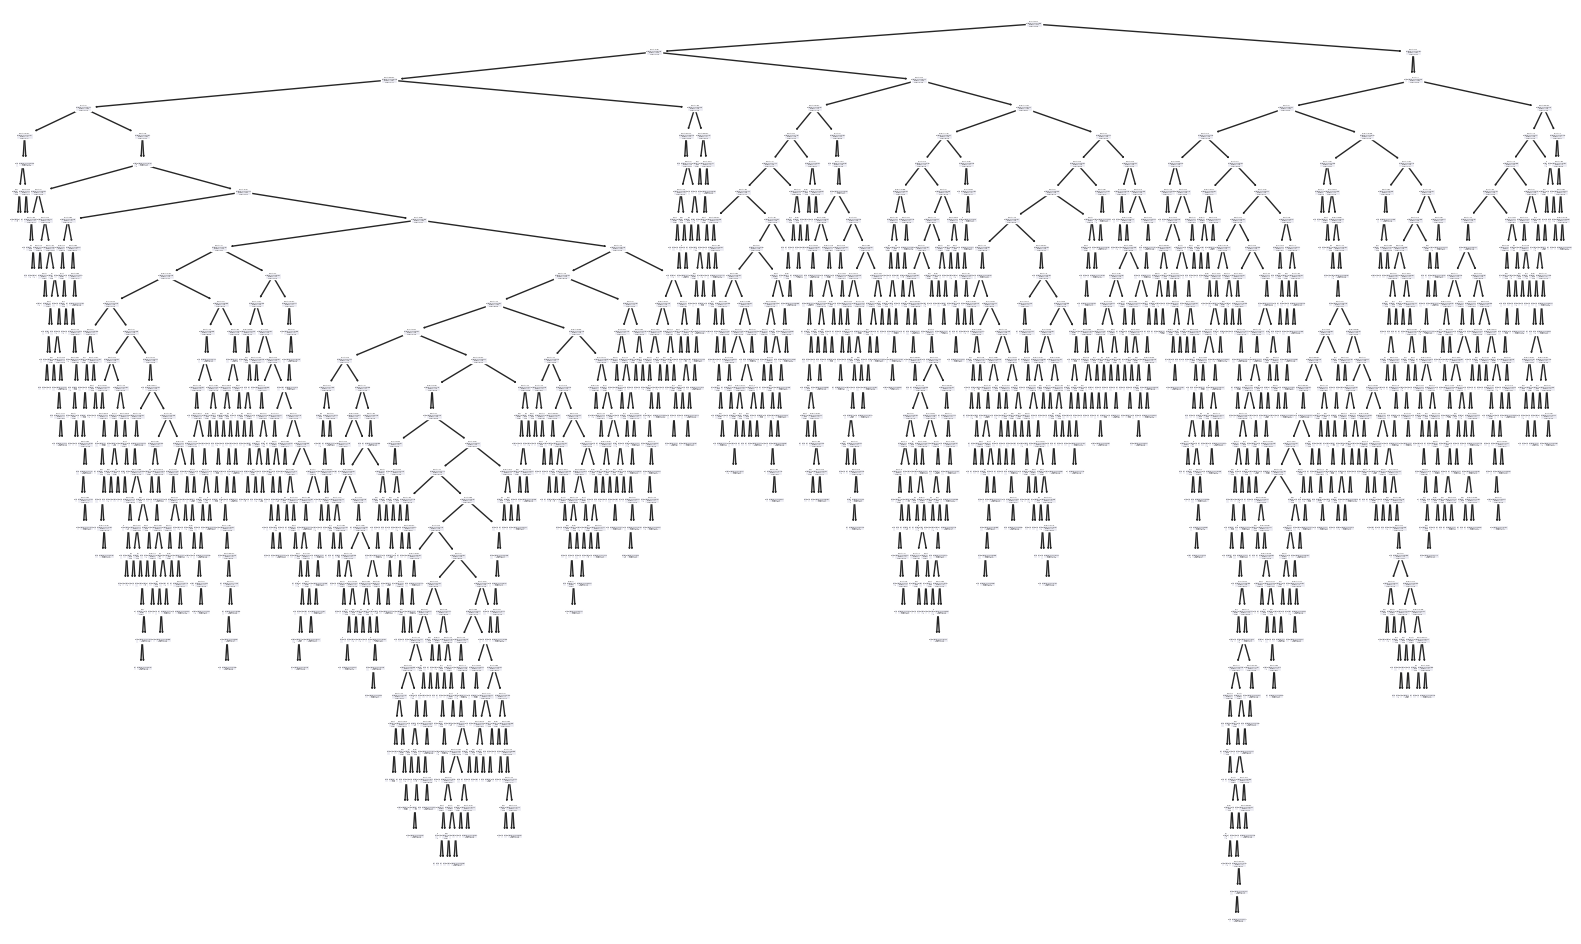

In [60]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn import tree


# Pick one tree from the forest, e.g., the last tree (index -1)
tree_to_plot = best_estimator[-1]

fig, ax = plt.subplots(figsize=(20,12))
tree.plot_tree(tree_to_plot, ax=ax)
plt.show()


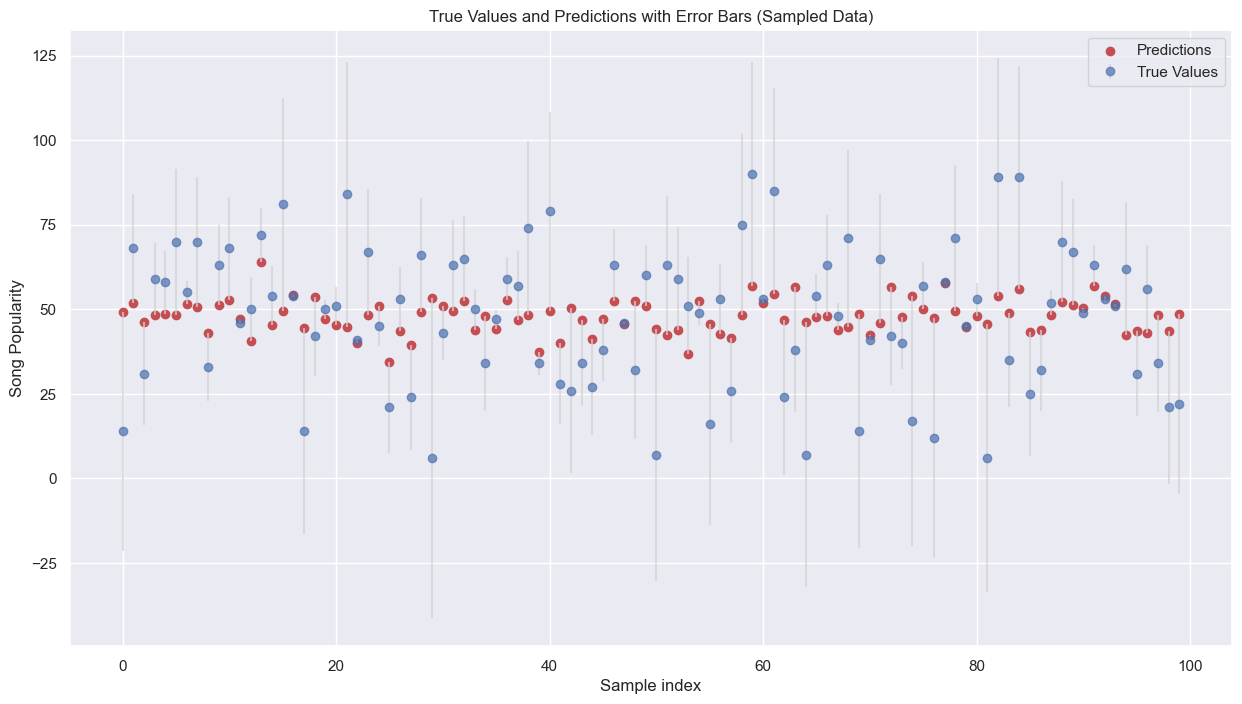

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Predict the values using the best model
predictions = best_model.predict(Test_X)

# Calculate the prediction errors
errors = np.abs(predictions - Test_Y.values)

# Sample a subset of the data for clearer visualization
sample_size = 100  # Adjust this value for your needs
indices = np.random.choice(range(len(Test_Y)), size=sample_size, replace=False)
sampled_true_values = Test_Y.iloc[indices].values
sampled_predictions = predictions[indices]
sampled_errors = errors[indices]

# Plotting
plt.figure(figsize=(15, 8))
plt.errorbar(range(sample_size), sampled_true_values, yerr=sampled_errors, fmt='o', label='True Values', ecolor='lightgray', alpha=0.7, linestyle='None')
plt.scatter(range(sample_size), sampled_predictions, color='r', label='Predictions')

plt.xlabel('Sample index')
plt.ylabel('Song Popularity')
plt.title('True Values and Predictions with Error Bars (Sampled Data)')
plt.legend()
plt.show()


### 7.2. <a id='toc7_2_'></a>[Árvore de Regressão](#toc0_)

As árvores de decisão são modelos baseados em conjunções e disjunções de regras que podem facilmente ser representadas sob a forma de uma árvore. 
Neste trabalho utiliso arvore de decisão para resolver um problema de Regressão (arvore de regressão).

Consideremos os dados "Song_popularity_Data" do "Kaggle", pretende-se criar um modelo preditivo da popularidade de musicas "Song popularity Data" com base em determinadas variaveis como a energia, a acustica, a instrumentalidade, a vivacidade, entre outros. A arvore de regressao é guiado pelo RMSE.

#### 7.2.1. <a id='toc7_2_1_'></a>[Existem diferentes pacotes para modelar com árvores de decisão. Aqui usaremos o tree.](#toc0_)

In [ ]:
%%R
library(readr) #clamar o pacote readr
install.packages("tree") #instalar o pacote tree (diz se a arvore é de classificação ou de regressão)
library(tree) #chamar o pacote tree


The downloaded binary packages are in
	/var/folders/km/dt_l1qsx1kvdth2cmx91yspm0000gn/T//RtmpqYzXIF/downloaded_packages


trying URL 'https://mirrors.cicku.me/cran/bin/macosx/big-sur-x86_64/contrib/4.3/tree_1.0-43.tgz'
Content type 'application/gzip' length 183668 bytes (179 KB)
downloaded 179 KB



In [ ]:
%%R -i df_LOF
song_data <- df_LOF

In [ ]:
%%R
# Vamos eliminar a primeira coluna nos dados

song_data1=song_data
head(song_data1)

  song_popularity song_duration_ms acousticness danceability energy
1              73

           262333     0.005520        0.496  0.682
2              66           216933     0.010300        0.542  0.853
3              76           231733     0.008170        0.737  0.463
4              74           216933     0.026400        0.451  0.970
5              56           223826     0.000954        0.447  0.766
6              80           235893     0.008950        0.316  0.945
  instrumentalness key liveness loudness audio_mode speechiness   tempo
1         2.94e-05   8   0.0589   -4.095          1      0.0294 167.060
2         0.00e+00   3   0.1080   -6.407          0      0.0498 105.256
3         4.47e-01   0   0.2550   -7.828          1      0.0792 123.881
4         3.55e-03   0   0.1020   -4.938          1      0.1070 122.444
5         0.00e+00  10   0.1130   -5.065          1      0.0313 172.011
6         1.85e-06   4   0.3960   -3.169          0      0.1240 189.931
  time_signature audio_valence
1              4         0.474
2              4         0.370
3           

#### 7.2.2. <a id='toc7_2_2_'></a>[Vamos dividir o conjunto de dados em dados de treio e de teste.](#toc0_)

In [ ]:
%%R

#___________
set.seed(1234) #fazer a mesma divisão dos conjuntos de teste e
#treino sempre que se executa o código
ind.tr=sample(1:nrow(song_data1),0.8*nrow(song_data))
song.tr=song_data1[ind.tr,] #Dados para treino
song.te=song_data1[-ind.tr,] #Dados para teste


#### 7.2.3. <a id='toc7_2_3_'></a>[Ajustamos uma árvore de regressão:](#toc0_)

In [ ]:
%%R

song.tree=tree(song_popularity~.,data=song.tr) #ajusta uma árvore
summary(song.tree) # faz um resumo da árvore ajustada


Regression tree:
tree(formula = song_popularity ~ ., data = song.tr)
Variables actually used in tree construction:
[1] "instrumentalness"
Number of terminal nodes:  2 
Residual mean deviance:  409.4 = 4874000 / 11910 
Distribution of residuals:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-50.590 -11.590   3.415   0.000  14.410  50.870 


A função tree identificou automaticamente que se trata de um problema de regressao  e utilizou apenas a variável "instrumentalness" para construir a árvore. De facto, as árvores de decisão têm esta vantagem: apenas utilizam as variáveis essenciais para resolver o problema (efetuam uma seleção de variáveis). A árvore contém 2 folhas (corespondendo a apenas duas regioes no plano) e tem um erro quadrático médio de 410 no conjunto de treino. O valor previsto em cada folha é o valor médio das observações de treino presentes na
região R_{j} correspondente. 

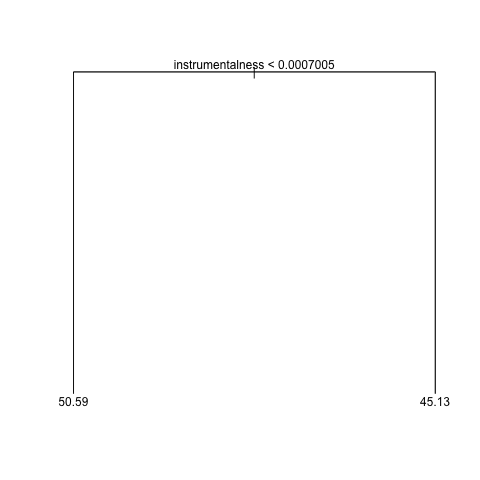

In [ ]:
%%R
plot(song.tree) #Apresenta as linhas da árvore
text(song.tree,pretty=0)#acrescenta  as variáveis que ganharam cara nó e as condições

#### 7.2.4. <a id='toc7_2_4_'></a>[O PROCESSO DE PODA](#toc0_)

Ainda que não faça sentido, devido o tamanha da árvo obtida, vamos valiar a possibilidade de obter ganhos com a poda da árvore:

In [ ]:
%%R
song.tree.cv=cv.tree(song.tree) #aplica o processo da poda
song.tree.cv # faz um resumo do processo aplicado

$size
[1] 2 1

$dev
[1] 4887737 4953939

$k
[1]     -Inf 78873.94

$method
[1] "deviance"

attr(,"class")
[1] "prune"         "tree.sequence"


Neste caso, a árvore original é a de melhor performance (ela apresenta menor erro com 2 folhas), pelo que não se aplica qualquer estratégia de poda. 

In [ ]:
%%R
pred=predict(song.tree,newdata=song.te) #avalia o madelo criado no conjunto de teste.
sqrt(mean((pred-song.te$song_popularity)^2))# calcula RMSE (podemos utilizar o MAPE para obter os erros em percentágens)

[1] 20.16712


O RMSE mede a diferença entre os valores previstos pelo modelo e os valores reias (observados) na variável resposta (song_popularity) e quanto menos melhor está em ajuste aos dados observados.

O RMSE 20.15817 indica que em média as previssões do modelo estão a uma distância de 20.16 do valor real e como a song_popularity está numa escala de 0 a 100 este RMSE significa que em média as previssões estão a cerca de 20% de distância do valor real.

#### 7.2.5. <a id='toc7_2_5_'></a>[A ÁRVIRE TMAX](#toc0_)

Mas, e se os critérios de paragem pré-estabelecidos no R são demasiado exigentes? Poderá a árvore construída com 2 folhas não ser a melhor porque o processo de construção terminou cedo demais? Podemos sempre forçar a árvore Tmax e aplicar a estratégia de poda.

In [ ]:
%%R
song.tmax=tree(song_popularity~.,data=song.tr, control = tree.control(nrow(song.tr),mindev=0.0005,minsize=2))
# mindev- controla o erro mínimo após a divisão.
#minsize-define o tamanho mínimo do nó antes da divisão.~
summary(song.tmax)# ap



Regression tree:
tree(formula = song_popularity ~ ., data = song.tr, control = tree.control(nrow(song.tr), 
    mindev = 5e-04, minsize = 2))
Number of terminal nodes:  272 
Residual mean deviance:  327.5 = 3810000 / 11640 
Distribution of residuals:
   Min. 1st Qu. 

 Median    Mean 3rd Qu.    Max. 
-58.380 -10.280   2.205   0.000  12.620  51.710 


A árvore obtida tem 346 folhas e um erro de aproximadamente  300. Á seguir temos duas representações  que em apenas uma apresenta as variáveis que ganhou cada nó.

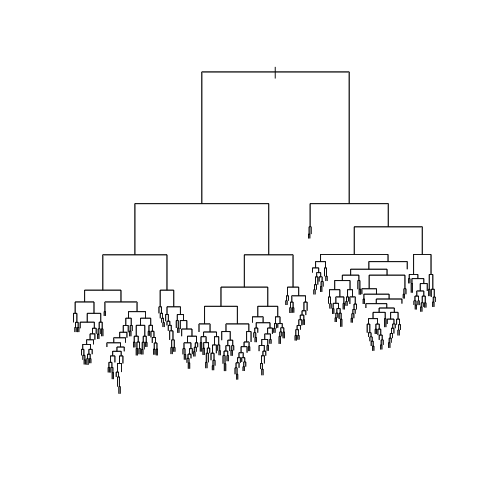

In [ ]:
%%R
plot(song.tmax) #Apresenta as linhas da árvore

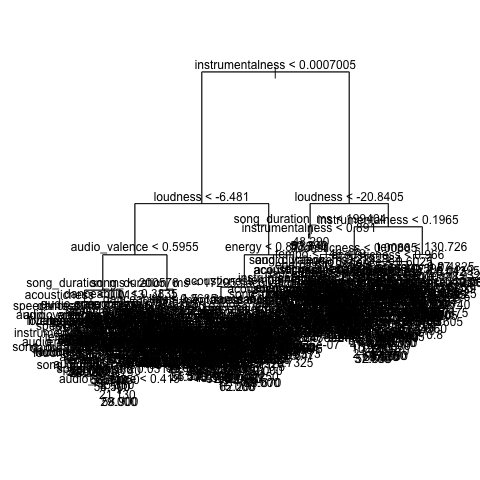

In [ ]:
%%R
plot(song.tmax) #Apresenta as linhas da árvore
text(song.tmax,pretty=0)#acrescenta  as variáveis que ganharam cara nó e as condições.

#### 7.2.6. <a id='toc7_2_6_'></a>[A PODA DA ÁRVIRE TMAX](#toc0_)

Aplicamos agora a estratégia de poda:

In [ ]:
%%R
song.tmax.cv=cv.tree(song.tmax) #aplica a poda
song.tmax.cv # faz um resumo da processo de poda

$size
  [1] 272 271 270 269 268 267 266 265 264 263 261 260 259 257 256 254 252 251
 [19] 249 248 247 246 242 241 240 236 234 233 232 231 230 229 228 227 226 225
 [37] 224 222 217 216 215 214 213 210 209 208 206 205 204 202 201 200 193 189
 [55] 188 187 185 184 183 180 177 176 175 174 173 172 167 166 165 162 156 155
 [73] 154 153 152 150 149 148 147 146 142 139 138 136 135 134 133 124 120 119
 [91] 118 116 106 105 102 100  99  98  87  82  79  75  74  73  71  70  65  61
[109]  60  59  58  57  56  55  53  52  51  50  49  44  43  40  39  37  35  32
[127]  31  30  29  26  22  21  20  19  18  16  15  14  13  12  11  10   9   8
[145]   7   5   4   3   2   1

$dev
  [1] 4884884 4884884 4884884 4884884 4884884 4884884 4884884 4884884 4884884
 [10] 4884884 4884884 4884884 4884884 4884884 4884884 4884884 4884884 4884884
 [19] 4884884 4884884 4884884 4884884 4884884 4884884 4884884 4884884 4884884
 [28] 4884884 4884884 4884884 4884884 4884884 4884884 4884884 4884884 4884884
 [37] 4884884 4884884 

Como podemos observar, entre 2 e 346 folhas a quantidade de erro é sempre a mesma (4285571) tornando- se óbvio que a árvore com 2 folhas tem a mesma performance que 346 folhas. Vejamos este resultado no gráfico que se segue:

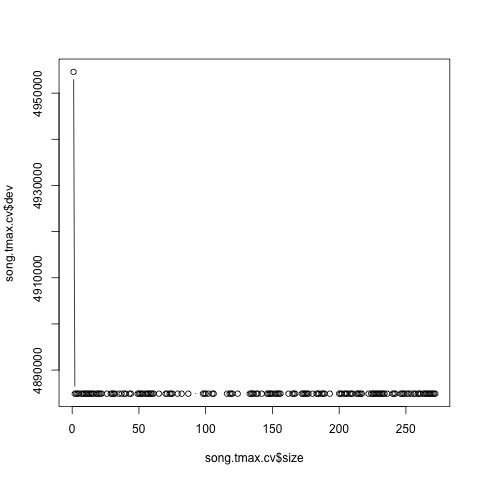

In [ ]:
%%R
plot(song.tmax.cv$size,song.tmax.cv$dev,type="b")
#O comando "type" especifica o tipo de gráfico. Neste caso, "b" 
#indica que quero um gráfico de disperssão com linhas conectando
#os pontos.

Já sabemos que entre perfórmances semelhantes é preferível o modelo mais ssímples.
Portanto, devemos podar a árvore de forma que fique com apenas 2 folhas.

Vamos aplicar a poda.

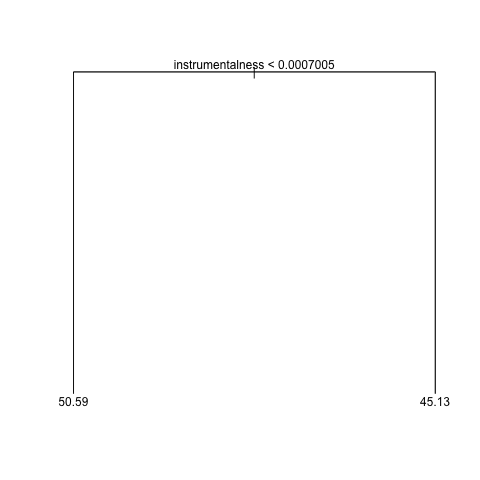

In [ ]:
%%R
prune.song.tmax.tree = prune.tree(song.tmax, best = 2, method = "deviance") # aplicar a pode de forma que a árvore podada tenha 4 folhas, conforme indicado no processo.
plot(prune.song.tmax.tree) #Apresenta as linhas da árvore
text(prune.song.tmax.tree,pretty=0) #acrescenta  as variáveis que ganharam cara nó e as condições.

Cocluimos que a árvore óptima tem mesmo duas folhas e que comparando o número de variável com a árvore obtida, podemos levantar duas questões: Os dados que utilizamos explicam a popularidade da música? A árvore de decisão é um bom modelo preditivo para tais dados?   

### 7.3. <a id='toc7_3_'></a>[Bagging](#toc0_)

In [41]:
%%R
install.packages("pls")
library(pls)
library(psych) 
library(readr)
library(tree)
library(caret)
library(gbm)
library(rpart)
library(rpart.plot)
library(randomForest)
library(caret)
library(pROC)
library(ggplot2)
library(reshape2)
library(dplyr)
install.packages("rdist")
library(rdist)
install.packages("dbscan")
library(dbscan)
install.packages("Rlof")
library(Rlof)


The downloaded binary packages are in
	/var/folders/km/dt_l1qsx1kvdth2cmx91yspm0000gn/T//RtmpQs4QHw/downloaded_packages

The downloaded binary packages are in
	/var/folders/km/dt_l1qsx1kvdth2cmx91yspm0000gn/T//RtmpQs4QHw/downloaded_packages

The downloaded binary packages are in
	/var/folders/km/dt_l1qsx1kvdth2cmx91yspm0000gn/T//RtmpQs4QHw/downloaded_packages

The downloaded binary packages are in
	/var/folders/km/dt_l1qsx1kvdth2cmx91yspm0000gn/T//RtmpQs4QHw/downloaded_packages


trying URL 'https://mirrors.cicku.me/cran/bin/macosx/big-sur-x86_64/contrib/4.3/pls_2.8-3.tgz'
Content type 'application/gzip' length 1183010 bytes (1.1 MB)
downloaded 1.1 MB

trying URL 'https://mirrors.cicku.me/cran/bin/macosx/big-sur-x86_64/contrib/4.3/rdist_0.0.5.tgz'
Content type 'application/gzip' length 1193861 bytes (1.1 MB)
downloaded 1.1 MB

trying URL 'https://mirrors.cicku.me/cran/bin/macosx/big-sur-x86_64/contrib/4.3/dbscan_1.1-12.tgz'
Content type 'application/gzip' length 4211624 bytes (4.0 MB)
downloaded 4.0 MB

trying URL 'https://mirrors.cicku.me/cran/bin/macosx/big-sur-x86_64/contrib/4.3/Rlof_1.1.3.tgz'
Content type 'application/gzip' length 37028 bytes (36 KB)
downloaded 36 KB



In [42]:
%%R -i df_LOF
data <- df_LOF
data.numeric <- data[,sapply(data, is.numeric)]

In [43]:
%%R
################### Aplicação da metodologia BAGGING

# Criação do conjunto de treino e de teste
ind.tr=sample(1:nrow(data),0.8*nrow(data))
data.tr=data[ind.tr,]
data.te=data[-ind.tr,]

head(data.tr)

      song_popularity song_duration_ms acousticness danceability energy
8088               44           385533       0.1670        0.768  0.861
12761              37           258133       0.3920        0.662  0.876
470                65           211066       0.2080        0.429  0.668
7119               20           200113       0.5190        0.418  0.907
11010              59           247106       0.0659        0.925  0.741
7906               60           301893       0.0143        0.767  0.776
      instrumentalness key liveness loudness audio_mode speechiness   tempo
8088          1.43e-04   2    0.420  -10.967          1      0.0883 113.599
12761         9.27e-06   4    0.132   -3.863          0      0.0429  98.334
470           0.00e+00   4    0.538   -7.539          0      0.0440  77.737
7119          9.13e-01   9    0.148   -8.694          1      0.2570 174.879
11010         0.00e+00   9    0.044   -5.827          0      0.3140  93.035
7906          0.00e+00   2    0.326   -8

In [44]:
%%R
song.bagg = randomForest(song_popularity ~ ., data = data.tr, 
                          mtry = (ncol(data.tr) - 1))
song.bagg



Call:
 randomForest(formula = song_popularity ~ ., data = data.tr, mtry = (ncol(data.tr) -      1)) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 13

          Mean of squared residuals: 401.0355
                    % Var explained: 3.12


In [45]:
%%R
# Prever os valores de popularidade das músicas no conjunto de teste
pred=predict(song.bagg,newdata=data.te)

In [46]:
%%R
# RMSE
sqrt(mean((pred-data.te$song_popularity)^2))

[1] 20.03218


In [47]:
%%R
# MAE (média dos valores absolutos)
mean(abs(pred - data.te$song_popularity))


[1] 15.67211


In [48]:
%%R
# R-sqrt (Coeficiente de deteminação)
cor(pred, data.te$song_popularity)^2

[1] 0.05157638


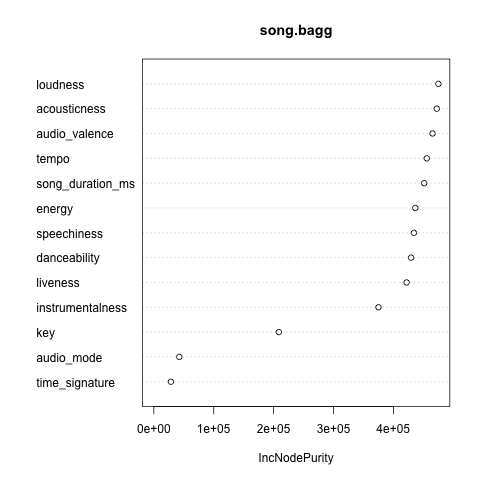

In [49]:
%%R
importance(song.bagg) # verificar as variáveis mais influentes no modelo

varImpPlot(song.bagg)

In [50]:
%%R
#################### Bagging para 2000 árvores

song.bagg2 = randomForest(song_popularity ~ ., data = data.tr, 
                          mtry = (ncol(data.tr) - 1), ntree = 2000)
song.bagg2


Call:
 randomForest(formula = song_popularity ~ ., data = data.tr, mtry = (ncol(data.tr) -      1), ntree = 2000) 
               Type of random forest: regression
                     Number of trees: 2000
No. of variables tried at each split: 13

          Mean of squared residuals: 399.6239
                    % Var explained: 3.46


In [51]:
%%R
# Prever os valores de popularidade das músicas no conjunto de teste
pred=predict(song.bagg2,newdata=data.te)

In [52]:
%%R
# RMSE
sqrt(mean((pred-data.te$song_popularity)^2))

[1] 20.00792


In [53]:
%%R
# MAE (média dos valores absolutos)
mean(abs(pred - data.te$song_popularity))

[1] 15.65171


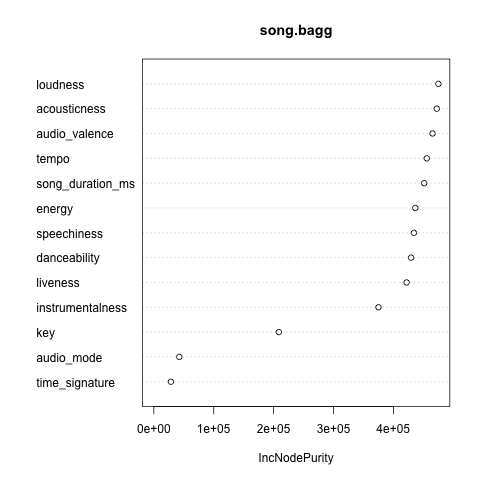

In [54]:
%%R
# R-sqrt (Coeficiente de deteminação)
cor(pred, data.te$song_popularity)^2
importance(song.bagg) # verificar as variáveis mais influentes no modelo
varImpPlot(song.bagg)

In [55]:
%%R
############ Aplicação da regularização para melhorar a performance do modelo
library(caret)
library(glmnet)

# Dividir os dados em variáveis preditoras (x) e variável resposta (y)
x_train = as.matrix(data.tr[, -which(names(data.tr) == "song_popularity")])
y_train = data.tr$song_popularity

x_test = as.matrix(data.te[, -which(names(data.tr) == "song_popularity")])
y_test = data.te$song_popularity

x = as.matrix(data[, -ncol(data)])  # todas as colunas menos a variável preditora
y = data[, ncol(data)]  # coluna da variável resposta

# Definir uma sequência de valores de lambda para testar
lambda_seq <- 10^seq(2, -2, by = -0.1)

Error in library(glmnet) : there is no package called ‘glmnet’


RInterpreterError: Failed to parse and evaluate line '############ Aplicação da regularização para melhorar a performance do modelo\nlibrary(caret)\nlibrary(glmnet)\n\n# Dividir os dados em variáveis preditoras (x) e variável resposta (y)\nx_train = as.matrix(data.tr[, -which(names(data.tr) == "song_popularity")])\ny_train = data.tr$song_popularity\n\nx_test = as.matrix(data.te[, -which(names(data.tr) == "song_popularity")])\ny_test = data.te$song_popularity\n\nx = as.matrix(data[, -ncol(data)])  # todas as colunas menos a variável preditora\ny = data[, ncol(data)]  # coluna da variável resposta\n\n# Definir uma sequência de valores de lambda para testar\nlambda_seq <- 10^seq(2, -2, by = -0.1)\n'.
R error message: 'Error in library(glmnet) : there is no package called ‘glmnet’'

In [ ]:
%%R
# 1. Treinar o modelo RIDGE
ridge_model <- glmnet(x_train, y_train, alpha = 0, lambda = lambda_seq)

# Cross-validation para encontrar o melhor valor de lambda
cv_ridge <- cv.glmnet(x_train, y_train, alpha = 0, lambda = lambda_seq)
best_lambda_ridge <- cv_ridge$lambda.min

# Predições e avaliação no conjunto de teste
ridge_predictions <- predict(ridge_model, s = best_lambda_ridge, newx = x_test)
ridge_rmse <- sqrt(mean((ridge_predictions - y_test)^2))
print(paste("Ridge RMSE:", ridge_rmse))

# Coeficientes do modelo Ridge
ridge_coefficients <- predict(ridge_model, s = best_lambda_ridge, type = "coefficients")
print("Ridge Coefficients:")
print(ridge_coefficients)

In [ ]:
%%R
# 2. Treinar o modelo LASSO
lasso_model <- glmnet(x_train, y_train, alpha = 1, lambda = lambda_seq)

# Cross-validation para encontrar o melhor valor de lambda
cv_lasso <- cv.glmnet(x_train, y_train, alpha = 1, lambda = lambda_seq)
best_lambda_lasso <- cv_lasso$lambda.min

# Predições e avaliação no conjunto de teste
lasso_predictions <- predict(lasso_model, s = best_lambda_lasso, newx = x_test)
lasso_rmse <- sqrt(mean((lasso_predictions - y_test)^2))
print(paste("Lasso RMSE:", lasso_rmse))

# Coeficientes do modelo Lasso
lasso_coefficients <- predict(lasso_model, s = best_lambda_lasso, type = "coefficients")
print("Lasso Coefficients:")
print(lasso_coefficients)

In [ ]:
%%R
# Validação cruzada para Ridge Regression
set.seed(123)  # Defina a semente para reprodutibilidade
cv_ridge <- cv.glmnet(X, y, alpha = 0)  # alpha = 0 para Ridge Regression
best_lambda_ridge <- cv_ridge$lambda.min
print(paste("Best lambda for Ridge Regression:", best_lambda_ridge))

# Validação cruzada para Lasso Regression
set.seed(123)  # Defina a semente para reprodutibilidade
cv_lasso = cv.glmnet(X, y, alpha = 1)  # alpha = 1 para Lasso Regression
best_lambda_lasso = cv_lasso$lambda.min
print(paste("Best lambda for Lasso Regression:", best_lambda_lasso))


# Ajustar o modelo final com o melhor lambda
final_ridge_model = glmnet(X, y, alpha = 0, lambda = best_lambda_ridge)
print(coef(final_ridge_model))

final_lasso_model = glmnet(X, y, alpha = 1, lambda = best_lambda_lasso)
print(coef(final_lasso_model))

In [ ]:
%%R
####################### Regularização Ridge no BAGGING

# Definir o controle de treinamento para validação cruzada
validacruz = trainControl(method = "cv", number = 5)

# Definir a grade de hiperparâmetros para o modelo Ridge
alpha = 0  # Lasso (alpha = 1) ou Ridge (alpha = 0)
lambda = 10^seq(-3, 3, by = 0.1)  # Varie os valores de lambda

# Ajustar o modelo Ridge usando Bagging
set.seed(123)
song.bagg_ridge_model = train(song_popularity ~ ., 
                            data = data.tr, 
                            method = "glmnet", 
                            trControl = validacruz, 
                            tuneGrid = expand.grid(alpha = alpha, lambda = lambda))

# Fazer previsões no conjunto de teste
predictions = predict(song.bagg_ridge_model, newdata = data.te)

# Avaliar o desempenho do modelo
mse = mean((predictions - data.te$song_popularity)^2)
rmse = sqrt(mse)
print(paste("RMSE:", rmse))


In [ ]:
%%R
############### ESTATÍSTICOS BÁSICOS #################

# Aplicamos essas técnicas estatísticas para entender melhor o 
# conjunto de dados e ter alguma intuição sobre como os algoritmos se 
# comportarão.

# Histograma de todas as variáveis
head(data)
dim(data)
hist(data$song_popularity)
# Maior densidade populacional no intervalo 
# [40,80] com caudas mais suaves e um aumento no valor de popularidade 0.
boxplot(data$song_popularity)

hist(data$song_duration_ms)
# A maioria das músicas se concentra no intervalo [0,500000], 
# o que é equivalente a um intervalo de 0 a 8 minutos aproximadamente. 
# Alguns elementos também estão em um intervalo maior do que este, 
# mas com uma densidade extremamente reduzida.
boxplot(data$song_duration_ms)

hist(data$acousticness) # talvez não
# Histograma do acousticness [0,1] x---->1 a música tem elementos acústicos.
##A maioria das músicas não apresentan elementos acústicos
boxplot(data$acousticness)

hist(data$danceability)
boxplot(data$danceability)

hist(data$energy)
boxplot(data$energy)

hist(data$instrumentalness)
boxplot(data$instrumentalness)

hist(data$key)
boxplot(data$key)

hist(data$liveness)
boxplot(data$liveness)

hist(data$loudness) 
boxplot(data$loudness)

hist(data$audio_mode) 
boxplot(data$audio_mode)

hist(data$speechiness) 
boxplot(data$speechiness)

hist(data$tempo)
# A maioria das músicas estão concentradas no intervalo [50,200] bpm(beats 
# por minuto)
boxplot(data$tempo)

hist(data$time_signature)
boxplot(data$time_signature)

hist(data$audio_valence)
boxplot(data$audio_valence)

In [ ]:
%%R
# Matriz de correlações dos dados e heatmap de correlações


data.numeric = data[,sapply(data, is.numeric)]
dim(data.numeric)

install.packages("reshape2")
library(reshape2)

correlation_matrix = cor(data.numeric)
correlation_data = melt(correlation_matrix)

# Criar o heatmap com ggplot2
ggplot(correlation_data, aes(Var1, Var2, fill = value)) +
  geom_tile(color = "white") +
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
                       midpoint = 0, limit = c(-1,1), 
                       space = "Lab", name="Correlation") +
  geom_text(aes(label = round(value, 2)), color = "black", size = 3) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, size = 10, hjust = 1)) +
  coord_fixed() +
  labs(title = "Correlation Heatmap", x = "Variables", y = "Variables")


# Não são extraídas grandes conclusões do heatmap, pelo menos não novas 
# conclusões em relação a uma intuição prévia. Fenômenos como o fato de que 
# a acústica e a energia da música estejam inversamente relacionadas ou que 
# a energia e a dançabilidade estejam diretamente correlacionadas são 
# fenômenos que poderiam ser presumidos previamente.


# Sendo que o Bagging não forneceu grandes resultados, optei por 
# categorizar as variáveis e aplicar a Classificação


In [ ]:
%%R
############# CATEGORIZAÇÃO DOS DADOS 

breaks <- c(0, 35, 60, 100) # intervalos
labels <- c("Não_popular", "Popular", "Frequência_rádio") # Criar etiquetas para categorias
data$song_category <- cut(data$song_popularity, breaks = breaks, labels = labels, include.lowest = TRUE)
head(data)
data
dim(data)

summary(data$song_category)
data$song_popularity <- NULL
data$song_name<-NULL
head(data)
dim(data)
summary(data$song_category)


dim(data)
View(data)

In [ ]:
%%R
##################### Bagging com dados categorizados

sapply(data, class)
data$song_category=as.factor(data$song_category)
data$time_signature=as.factor(data$time_signature)
data$audio_mode=as.factor(data$audio_mode)

library(readr)
set.seed(1234)
ind.tr=sample(1:nrow(data),0.8*nrow(data))
data.tr=data[ind.tr,]
data.te=data[-ind.tr,]



library(randomForest)
head(data.tr)
song.bagg3=randomForest(song_category~.,data=data.tr,mtry=(ncol(data.tr)-1))
song.bagg3




pred=predict(song.bagg3,newdata=data.te,type="class")
pred1=predict(song.bagg3,newdata=data.te,type="prob")
caret::confusionMatrix(pred,data.te$song_category)

varImpPlot(song.bagg3)

In [ ]:
%%R
##  Bagging com dados categorizados para 2000 árvores

song.bagg4 = randomForest(song_category ~ ., data = data.tr, 
                          mtry = (ncol(data.tr) - 1), ntree = 2000)
song.bagg4

pred=predict(song.bagg4,newdata=data.te,type="class")
pred1=predict(song.bagg4,newdata=data.te,type="prob")
caret::confusionMatrix(pred,data.te$song_category)

varImpPlot(song.bagg4)
boxplot(data$song_category)



head(pred1)
pred

In [ ]:
%%R
######## Curva ROC

if (!requireNamespace("pROC", quietly = TRUE)) {
  install.packages("pROC")
}

# Carregar a biblioteca 'pROC'
library(pROC)



roc_curves <- multiclass.roc(data.te$song_category, pred1)

# Calculate AUC
auc_score <- auc(roc_curves)
# Print AUC (curva ROC)
print(auc_score) ## o print diz que em 59% o classificador clasifica bem. 

In [ ]:
%%R
####### Algums estatísticos adicionais

# 1. variável song_duartion_ms

# variância
var(data$song_duration_ms[data$song_category == "Não_popular"])
var(data$song_duration_ms[data$song_category == "Popular"])
var(data$song_duration_ms[data$song_category == "Frequência_rádio"])


# média
mean(data$song_duration_ms[data$song_category == "Não_popular"])/60000
mean(data$song_duration_ms[data$song_category == "Popular"])/60000
mean(data$song_duration_ms[data$song_category == "Frequência_rádio"])/60000

# mediana
median(data$song_duration_ms[data$song_category == "Não_popular"])/60000
median(data$song_duration_ms[data$song_category == "Frequência_rádio"])/60000
median(data$song_duration_ms[data$song_category == "Popular"])/60000


# 2. acousticness

# variância
var(data$acousticness[data$song_category == "Não_popular"])
var(data$acousticness[data$song_category == "Frequência_rádio"])
var(data$acousticness[data$song_category == "Popular"])


# média
mean(data$acousticness[data$song_category == "Não_popular"])
mean(data$acousticness[data$song_category == "Frequência_rádio"])
mean(data$acousticness[data$song_category == "Popular"])


# mediana
median(data$acousticness[data$song_category == "Não_popular"])
median(data$acousticness[data$song_category == "Frequência_rádio"])
median(data$acousticness[data$song_category == "Popular"])

## 8. <a id='toc8_'></a>[Resultados](#toc0_)

## 9. <a id='toc9_'></a>[Considerações finais](#toc0_)